In [2]:
!pip install rtdl libzero optuna
!pip uninstall zero

# Zero Linear electronic circuit utility. This package provides tools to simulate responses and noise in linear electronic circuits, SI unit parsing and formatting, datasheet grabbing, and more.
# libzero: A zero-overhead library for PyTorch users

     |████████████████████████████████| 308 kB 9.4 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 210 kB 45.5 MB/s 
     |████████████████████████████████| 81 kB 5.5 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 112 kB 53.6 MB/s 
     |████████████████████████████████| 146 kB 48.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ca7af7fcb93c09548b0d9207c24da59d07b9b8f416555446e0c1c2dfff1c1efe
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

def objective(trial, df, y):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1e2),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1e2),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1e2)
    }
    kf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
    y_hats = []
    y_tests = []

    for train_index, test_index in kf.split(df, y):
        X_train, X_test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)
        y_hats += model.predict(X_test).tolist()
        y_tests += y_test.tolist()

    return f1_score(y_tests, y_hats)


X = pd.read_csv("X.csv")
X = X.set_index("token_address")
labels = pd.read_csv("labeled_list.csv", index_col="token_address")
X = X.merge(labels['label'], left_index=True, right_index=True)
X = X.reset_index()
df = X.drop_duplicates(subset=['token_address'])
X = X.set_index("token_address")
lock_features = pd.read_csv("token_lock_features.csv", index_col="token_address")
X = X.merge(lock_features, how='left', left_index=True, right_index=True)
optuna.logging.set_verbosity(optuna.logging.WARNING)

ids = []
total_probs = []
total_targets = []

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
for fold, (t, v) in enumerate(skfolds.split(df['token_address'], df['label'])):

    ids_train = df['token_address'].iloc[t]
    df_train = X.loc[ids_train]
    ids_test = df['token_address'].iloc[v]
    df_test = X.loc[ids_test]

    X_train, y_train = df_train.drop(["label", "eval_block"], axis=1), df_train['label']
    X_test, y_test = df_test.drop(["label", "eval_block"], axis=1), df_test['label']

    columns = X_train.columns

    func = lambda trial: objective(trial, X_train.copy(), y_train.copy())
    study = optuna.create_study(direction='maximize')
    study.optimize(func, n_trials=100)

    model = xgb.XGBClassifier(**study.best_params)
    model.fit(X_train, y_train)
    preds_scorings = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds)
    sensibilitat = recall_score(y_test, preds)
    precisio = precision_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    print("{},{},{},{},{}".format(accuracy, sensibilitat, precisio, f1, fold))
    ids += X_test.index.tolist()
    total_probs += preds.tolist()
    total_targets += y_test.tolist()

final_df = pd.DataFrame({'ids': ids, 'Pred': total_probs, 'Label': total_targets})\
    .to_csv("Results_XGBoost.csv", index=False)

0.9923312883435583,0.9568,0.9707792207792207,0.9637389202256244,0
0.9902945683636983,0.9424,0.9655737704918033,0.9538461538461538,1
0.9906319196048373,0.9436392914653784,0.966996699669967,0.9551752241238793,2
0.994031377899045,0.9564516129032258,0.9866888519134775,0.9713349713349713,3
0.9868824531516184,0.8985507246376812,0.9755244755244755,0.9354568315171836,4


In [5]:
model

XGBClassifier(alpha=2.4211245096508372e-05, gamma=6.099321795327694e-08,
              lambda=0.0028001321303806636, learning_rate=0.6738510712053398,
              max_depth=6, subsample=0.9795633937910987)

In [7]:
!pip install shap

     |████████████████████████████████| 564 kB 4.7 MB/s 


In [9]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)

In [15]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

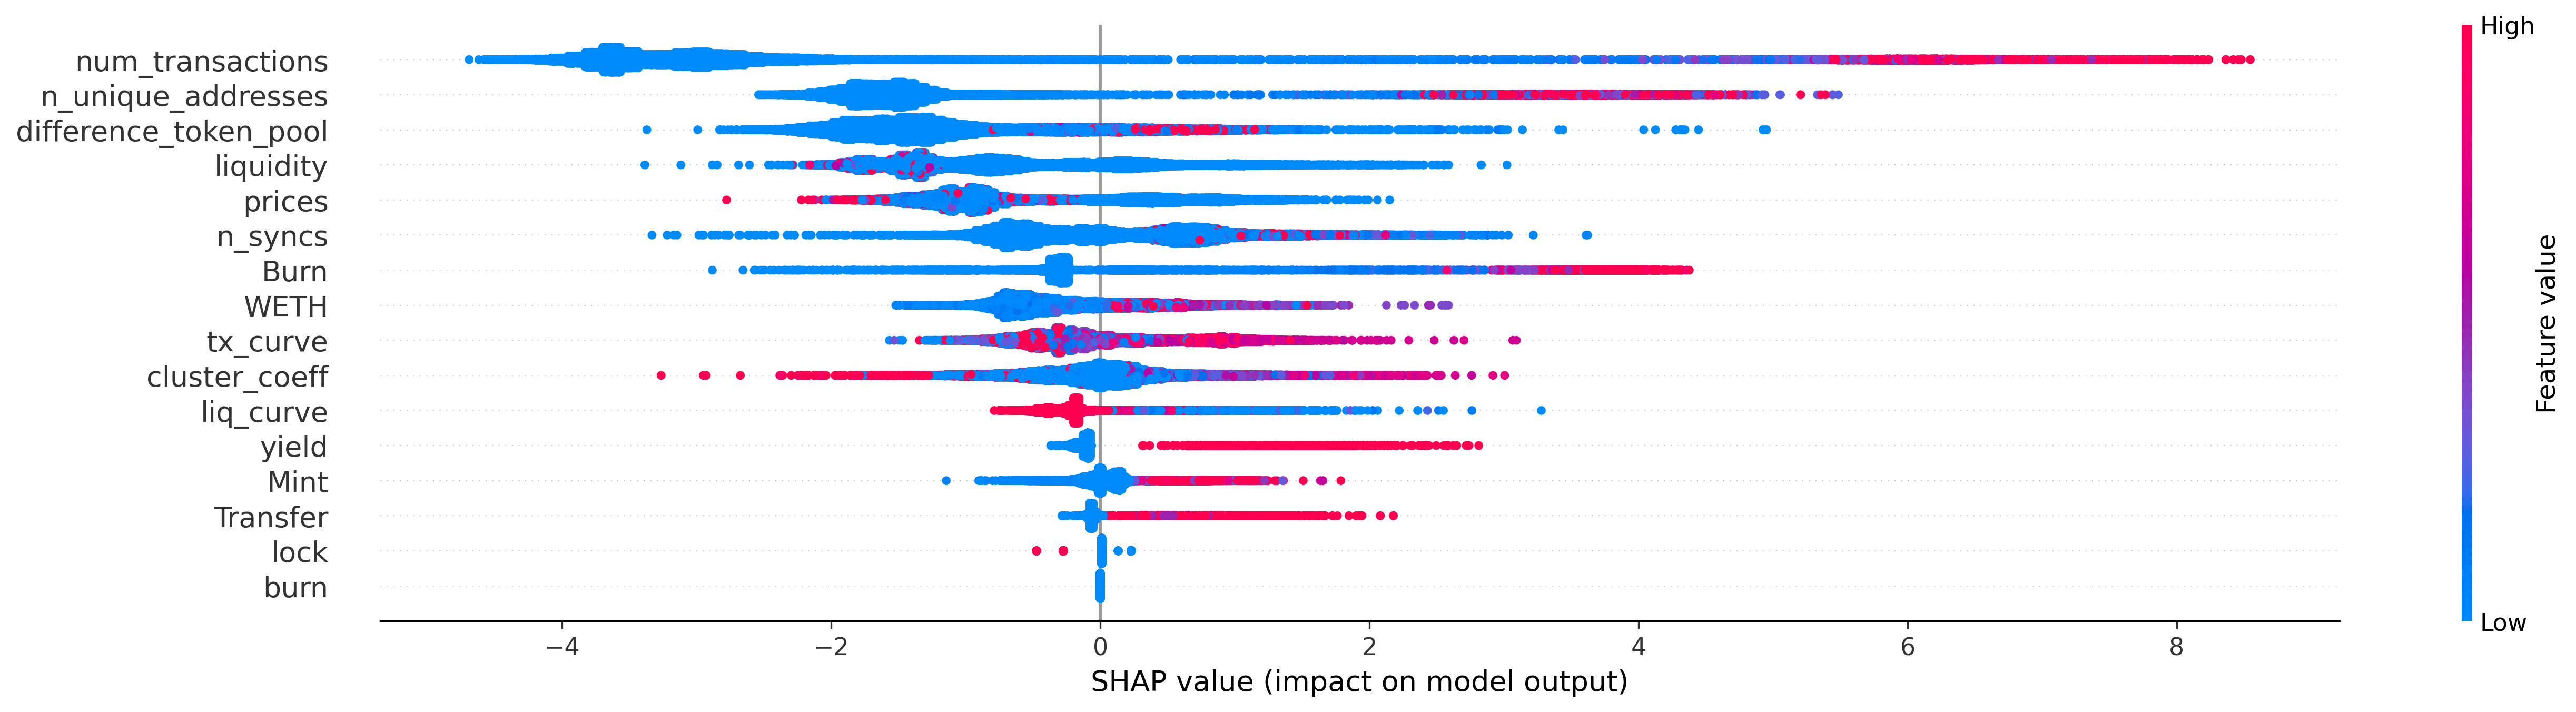

In [16]:
shap.summary_plot(shap_values, X_train, plot_size = (20, 5))

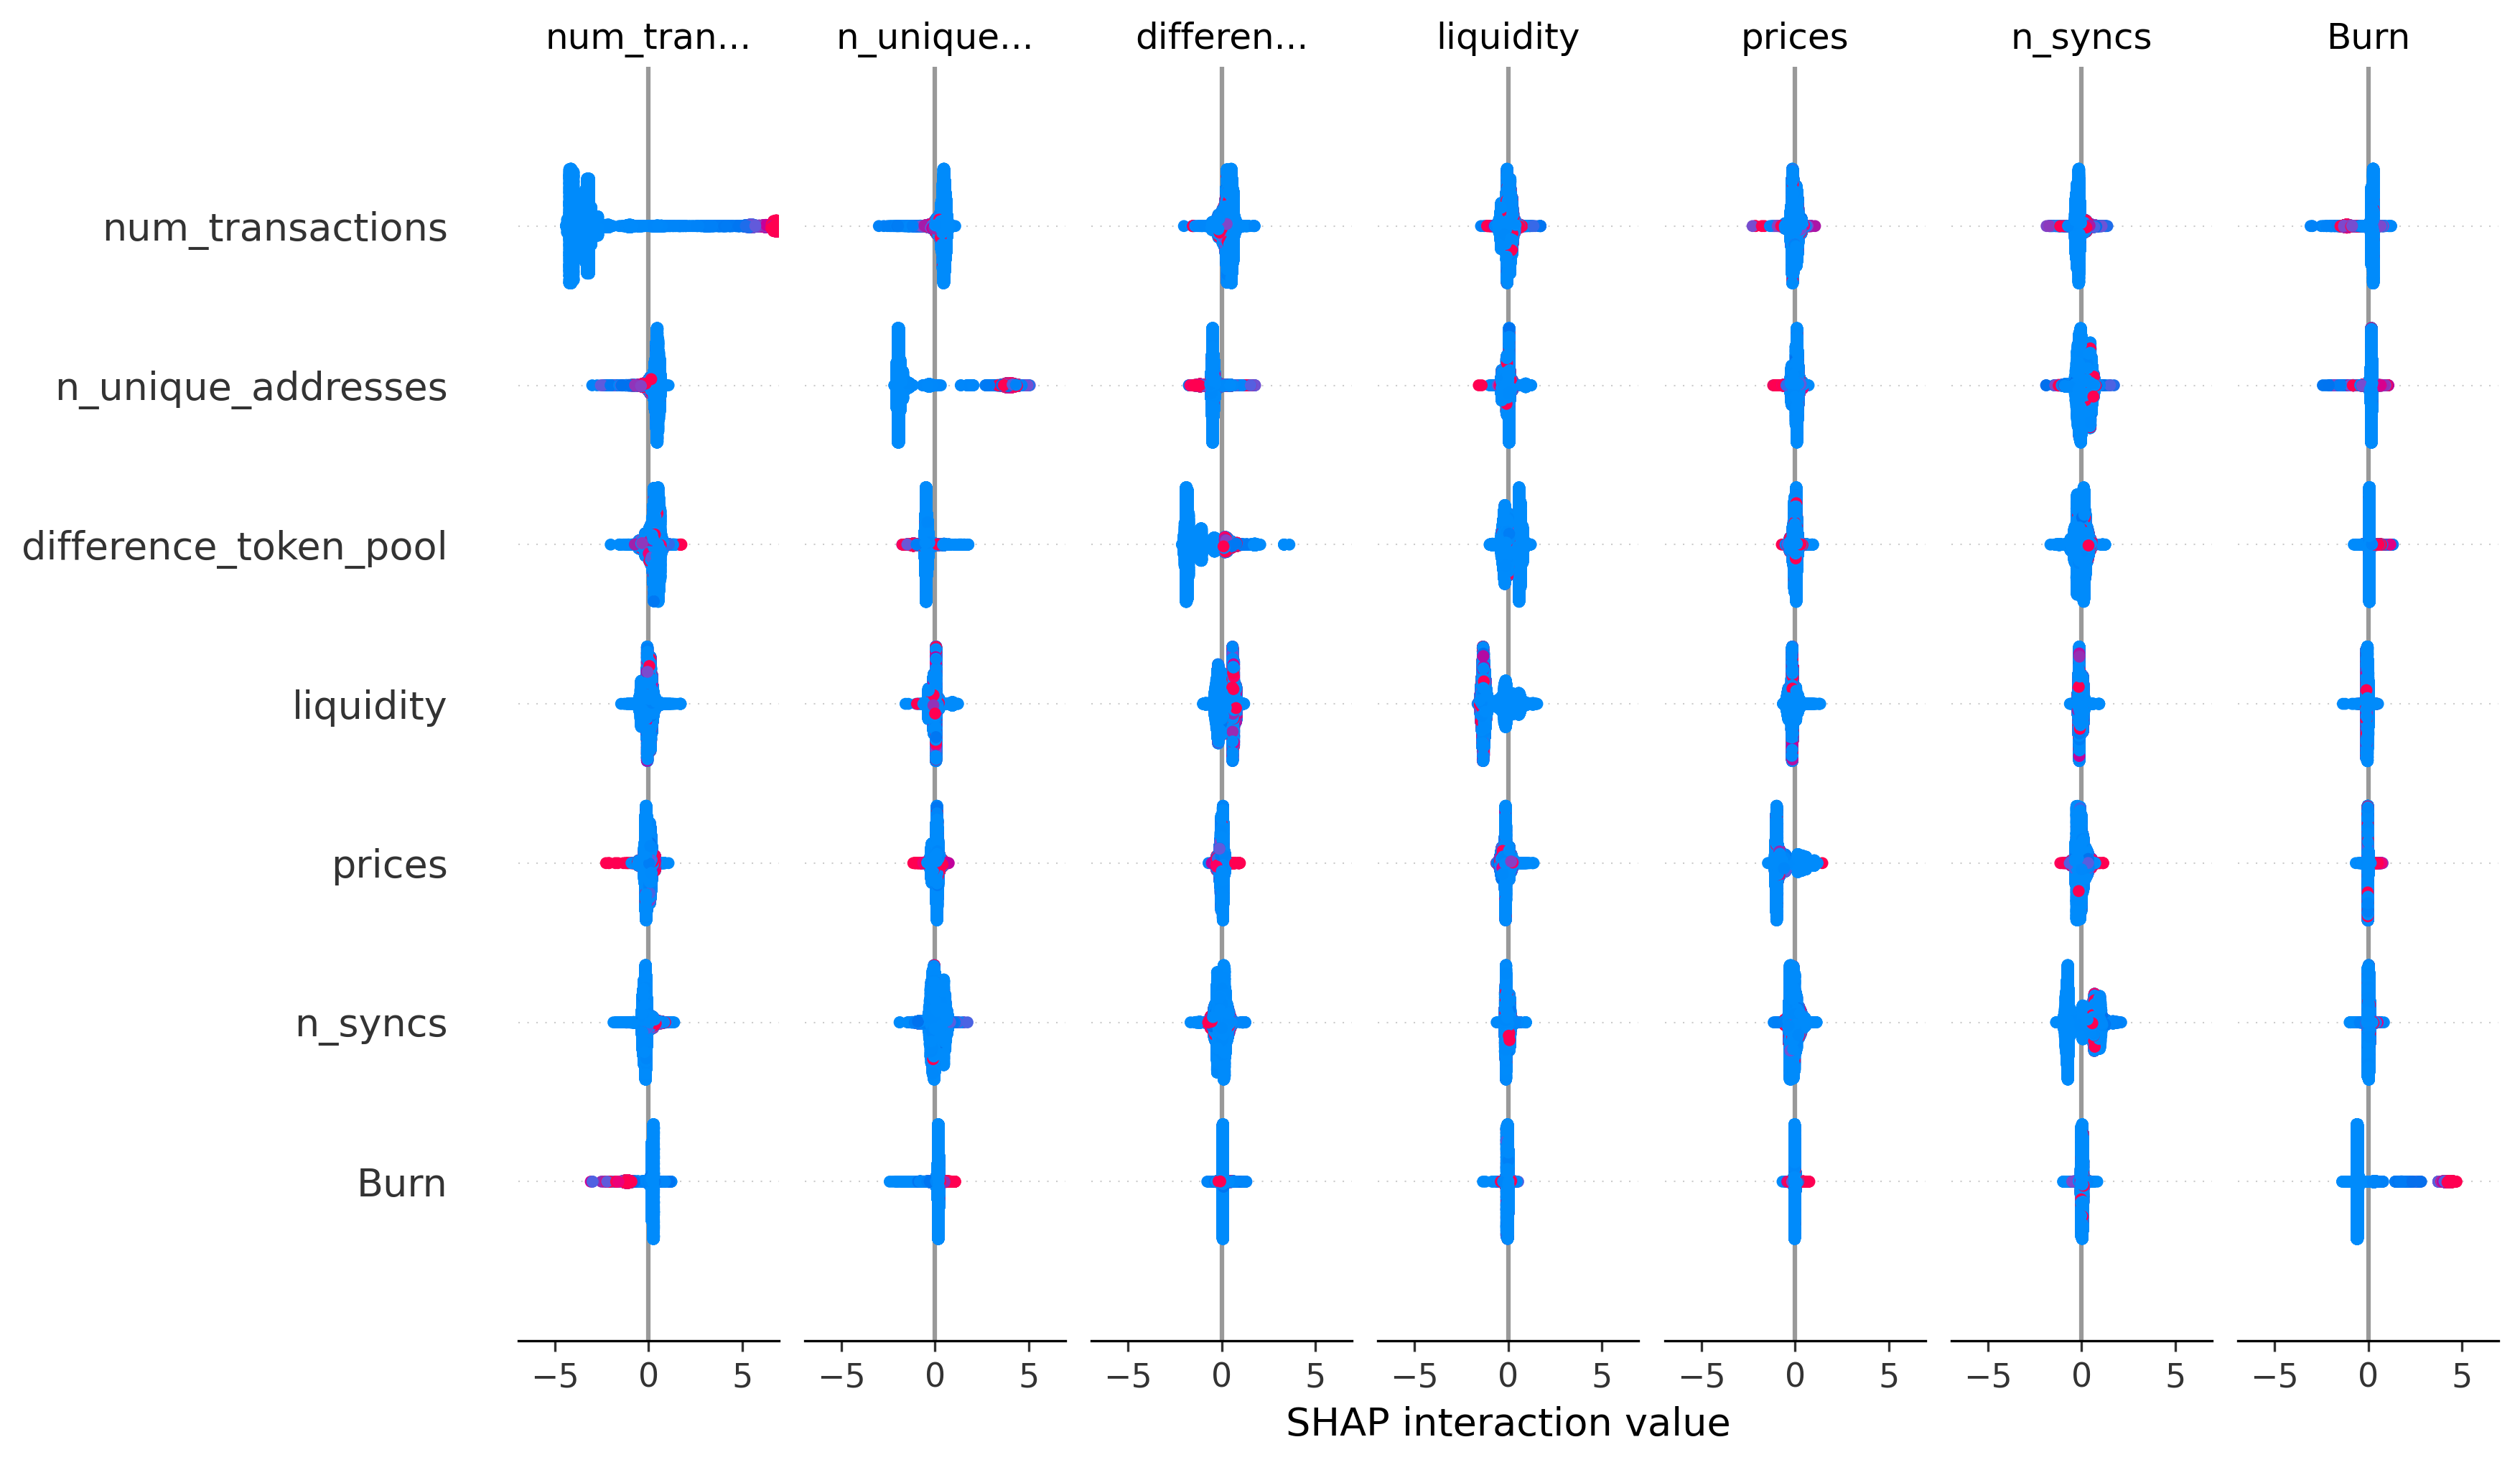

In [17]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train)
shap.summary_plot(shap_interaction_values, X_train)

In [18]:
X

,eval_block,num_transactions,n_unique_addresses,cluster_coeff,tx_curve,liq_curve,Mint,Burn,Transfer,difference_token_pool,n_syncs,WETH,prices,liquidity,label,burn,lock,yield
token_address,,,,,,,,,,,,,,,,,,
0x0000000000004946c0e9F43F4Dee607b0eF1fA1c,10893848,511765,27012,0.145429,0.013266,0.146127,342,359,3,50.0,21708,169.264731,2.576759e-03,1.111883e+07,1,0.0,0.0,0.0
0x0000000000004946c0e9F43F4Dee607b0eF1fA1c,11054253,675246,30627,0.145429,0.016350,0.110452,372,398,4,50.0,24771,44.602143,8.251557e-04,2.410880e+06,1,0.0,0.0,0.0
0x0000000000004946c0e9F43F4Dee607b0eF1fA1c,11163634,756347,31285,0.145429,0.015122,0.117496,380,414,4,50.0,27455,36.628668,5.436053e-04,2.468076e+06,1,0.0,0.0,0.0
0x0000000000004946c0e9F43F4Dee607b0eF1fA1c,12623280,2222064,43415,0.145429,0.024253,0.275483,487,643,9,50.0,67172,17.873854,1.963534e-04,1.627039e+06,1,0.0,0.0,0.0
0x0000000000004946c0e9F43F4Dee607b0eF1fA1c,13112399,2538548,44694,0.145429,0.017856,0.605033,491,658,10,50.0,74064,8.369961,9.697444e-05,7.224197e+05,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xffc706856ACCAed10931bdc5681467745bd943f4,11517942,35,26,0.000000,0.991121,1.000000,2,0,0,19.0,34,50.686226,5.688663e-05,4.516164e+07,0,0.0,0.0,0.0
0xffea00198Be8e644E114dc57d3F1cA062DaBF543,12289277,5,6,0.000000,0.935772,1.000000,2,0,0,121.0,4,6.204424,6.415171e-12,6.000599e+12,0,0.0,0.0,0.0
0xfff258BdccF6059EFC39F997F38AC42673b7AC03,12593635,17,14,0.000000,0.230768,1.000000,2,0,0,28.0,15,5.213620,1.085615e-14,2.503820e+15,0,0.0,0.0,0.0
